In [10]:
import math
# import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

In [11]:
def read_scores(path):
    # 0: common family sequences, 1: not common family but common class sequences, 2: no common family and class
    res = {0: [], 1: [], 2: []}
    with open(path, 'r') as f:
        all_cnt = 0; cnt1 = 0; cnt2 = 0
        for line in f:
            q, t, sc = map(str, line.split())
            qs = q.split('|')[1].split(',')
            ts = t.split('|')[1].split(',')
            score = int(sc)
            if set(qs).isdisjoint(ts):
                qs2 = list(map(lambda x: x.split(".")[0], qs))
                ts2 = list(map(lambda x: x.split(".")[0], ts))
                if set(qs2).isdisjoint(ts2):
                    cnt2 += 1
                    res[2].append(score)
                else:
                    res[1].append(score)
                cnt1 += 1
            else:
                res[0].append(score)
            all_cnt += 1
    return res, all_cnt, cnt1, cnt2
prev_res = read_scores('TestSamples/sample_bench_output_prevsub.tsv')
new_res = read_scores('TestSamples/sample_bench_output_newsub.tsv')

In [3]:
mx = int(1e4)
scale_div = math.log10(mx)
def log_scale(score):
    # >=10^5 -> 1, 1 -> 0
    return math.log10(min(mx, score)) / scale_div

def lin_scale(score):
    return min(mx, score) / mx

def log_scale_inv(value):
    return 10 ** (scale_div * value)

def lin_scale_inv(value):
    return value * mx

In [14]:
def plot_data(dict_data, map_func=log_scale, labels=["Same Family", "Same Class", "None!"], xlim_range=None, save_fig=True, save_path='bench_hist.png'):
    res = {k: list(map(lambda x: map_func(x), v)) for k, v in dict_data.items()}
    for k in res.keys():
        plt.hist(res[k], label=k, alpha=0.5)
        if xlim_range:
            plt.xlim(xlim_range)

    plt.legend(labels)
    if save_fig:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


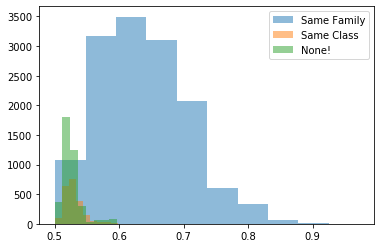

In [15]:
plot_data(new_res[0], log_scale)

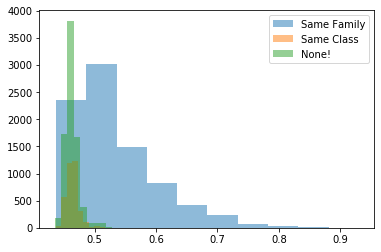

In [16]:
plot_data(prev_res[0])

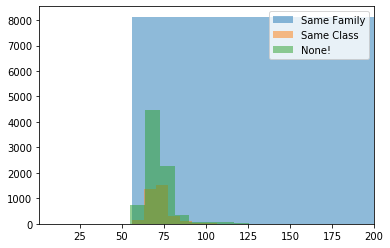

In [17]:
plot_data(prev_res[0], lambda x: x, xlim_range=(1, 200))

# ROC Curve

In [18]:
def roc_plot(dict_data, map_func=log_scale, thr_num=50000, save_fig=True, save_path='roc.png'):
    def rates(trues, falses, thr):
        tpr = len(trues[trues > thr]) / len(trues)
        fpr = len(falses[falses > thr]) / len(falses)
        return tpr, fpr, thr

    thresholds = np.linspace(0, 1, 50000)
    tmp = copy.deepcopy(dict_data)
    tmp[1] += tmp[2]

    trues = np.array([map_func(score) for score in tmp[0]])
    falses = np.array([map_func(score) for score in tmp[1]])

    points = []
    for thr in thresholds:
        tmp1 = rates(trues, falses, thr)
        points.append(tmp1)
    pivot = pd.DataFrame(points, columns=["y", "x", 'threshold'])
    plt.plot(pivot.x, pivot.y)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if save_fig:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    auc_score = round(abs(np.trapz(pivot.y, pivot.x)), 4)
    return pivot, auc_score, points


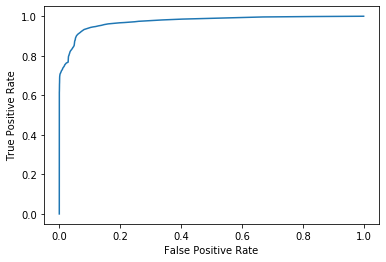

0.9731

In [19]:
pivot, auc_score, points = roc_plot(new_res[0], log_scale)
auc_score

# AUC Score

In [20]:
round(abs(np.trapz(pivot.y, pivot.x)), 4)

0.9731

In [21]:
ans = [(p[0] - p[1], log_scale_inv(p[2])) for p in points]
ans.sort(reverse=True)
ans[:10]

[(0.8515156812487182, 153.98689065423062),
 (0.8515156812487182, 153.9585272658928),
 (0.8515156812487182, 153.93016910190732),
 (0.8515156812487182, 153.9018161613122),
 (0.8515156812487182, 153.87346844314507),
 (0.8515156812487182, 153.84512594644406),
 (0.8515156812487182, 153.81678867024763),
 (0.8515156812487182, 153.78845661359384),
 (0.8515156812487182, 153.76012977552165),
 (0.8515156812487182, 153.73180815506944)]